In [1]:
import awr_configs
import learning.awr_agent as awr_agent
import gym
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import torch
import util.rl_path as rl_path
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [333]:
configs = awr_configs.AWR_CONFIGS['LunarLanderContinuous-v2']
configs["action_std"] = 0.2

In [340]:
env = gym.make("LunarLanderContinuous-v2")
graph = tf.Graph()
sess = tf.Session(graph=graph)
agent = awr_agent.AWRAgent(env=env, sess=sess, **configs)

In [341]:
agent.load_model("output/model.ckpt")

INFO:tensorflow:Restoring parameters from output/model.ckpt
Model loaded from: output/model.ckpt


In [342]:
def sample_action(agent, s, action_std):
    n = len(s.shape)
    s = np.reshape(s, [-1, agent.get_state_size()])

    feed = {
        agent._s_tf : s
    }

    run_tfs = [agent._norm_a_pd_tf.parameters["loc"]]

    out = agent._sess.run(run_tfs, feed_dict=feed)
    loc = torch.tensor(out[0])
    
    a = np.array(torch.distributions.Normal(loc, scale=action_std).sample().tolist())
    
    if n == 1:
        a = a[0]
    
    return a

In [353]:
def rollout_path(agent, action_std):
    path = rl_path.RLPath()

    s = agent._env.reset()
    s = np.array(s)
    path.states.append(s)

    done = False
    while not done:
        a = sample_action(agent, s, action_std)
        s, r, done, info = agent._step_env(a)
        s = np.array(s)

        path.states.append(s)
        path.actions.append(a)
        path.rewards.append(r)
        path.logps.append(0)

    path.terminate = agent._check_env_termination()

    return path

In [ ]:
paths = []
for _ in tqdm(range(10000)):
    paths.append(rollout_path(agent, 0.5))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
pickle.dump(paths, open("../awr/paths.5.pkl", "wb"))

In [8]:
def gather_data(num_episodes, agent, action_std):
    episodes = []
    
    for _ in tqdm(range(num_episodes)):
        path = rollout_path(agent, action_std)
        I = np.hstack([np.array(path.states)[:-1], np.array(path.actions)])
        R = path.rewards
        S2 = np.array(path.states)[1:]
        episodes.append((I, R, S2))
        
    return episodes

In [ ]:
# datas = []
# stds = [0.1, 0.3, 0.5, 0.7, 0.9]

# for std in stds:
#     data = gather_data(2000, agent, std)
#     datas += data
# random.shuffle(datas)

# pickle.dump(datas, open("data.mixed.pkl", "wb"))

In [307]:
# import pickle
# pickle.dump(data, open("data.5.pkl", "wb"))
data = pickle.load(open("data.5.pkl", "rb"))

In [310]:
import gym
import numpy as np
import random
from sklearn.ensemble import ExtraTreesRegressor
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

In [311]:
class Policy(nn.Module):
    """Policy class with an epsilon-greedy dqn model"""
    def __init__(self, agent, action_std):
        super().__init__()
        self.agent = agent
        self.action_std = action_std

    def forward(self, states):
        return sample_action(self.agent, states, self.action_std)

In [312]:
import torch
import torch.nn as nn

class Q(nn.Module):
    """Q-network using a NN"""
    def __init__(self, state_dim, action_dim, lr):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fitted = False
        
        self.model = nn.Sequential(
            nn.Linear(self.state_dim + self.action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        
    def forward(self, state):
        """Forward"""
        state = torch.tensor(state).cuda().float()
        return self.model(state)
    
    def predict(self, state):
        """Forward without gradients (used for predictions)"""
        state = torch.tensor(state).cuda().float()
        with torch.no_grad():
            return self.model(state).squeeze().cpu().numpy()
    
    def fit(self, state, true_value):
        """Fit NN with a single backward step"""
        self.fitted = True
        state = torch.tensor(state).cuda().float()
        true_value = torch.tensor(true_value).cuda().float()
        self.optimizer.zero_grad()
        out = self(state).squeeze()
        loss = self.criterion(out, true_value)
        loss.backward()
        self.optimizer.step()

In [313]:
def is_fitted(sklearn_regressor):
    """Helper function to determine if a regression model from scikit-learn
    has ever been `fit`"""
    return hasattr(sklearn_regressor, 'n_outputs_')

In [314]:
datas = data
terminals = []
for el in datas:
    terminal = np.ones(len(el[0]))
    terminal[-1] = 0
    terminals.append(terminal)

In [315]:
datas2 = []
for el,terminal in zip(datas, terminals):
    datas2.append((el[0],el[1],el[2],terminal))

In [317]:
class FittedQEvaluation(object):
    def __init__(self, regressor=None):
        self.regressor = regressor or ExtraTreesRegressor()
        self.tree_regressor = regressor is None
        
    def regressor_fitted(self):
        if self.tree_regressor:
            return is_fitted(self.regressor)
        else:
            return self.regressor.fitted
        
    def Q(self, state_actions):
        """Return the Q function estimate of `states` for each action"""    
        if not self.regressor_fitted():
            return np.zeros(state_actions.shape[0])
        return self.regressor.predict(state_actions)

    def fit_Q(self, eval_policy, episodes, num_iters=100, discount=0.95):        
        batches = []
        batch_len = len(episodes) // 10
        
        for i in range(10):
            Is = []
            S2s = []
            Rs = []
            Ts = []

            for I,R,S2,T in episodes[i * batch_len : (i + 1) * batch_len]:
                Is.append(I)
                Rs.append(R)
                S2s.append(S2)
                Ts.append(T)
            
            batches.append((np.concatenate(Is, 0), np.concatenate(Rs, 0),
                            np.concatenate(S2s, 0), np.concatenate(Ts, 0)))
        
        for i in tqdm(range(num_iters)):
            ins = []
            outs = []
            for (Is, Rs, S2s, Ts) in batches:
                ins.append(Is)
                pi_S2s = eval_policy(S2s)
                S2pi_S2s = np.hstack([S2s, pi_S2s])
                Os = Rs + discount * (Ts * self.Q(S2pi_S2s))
                outs.append(Os)
            for (Is, Os) in zip(ins, outs):
                self.regressor.fit(Is, Os)    

In [318]:
qnn = Q(agent.get_state_size(), agent.get_action_size(), 0.001).cuda()

In [319]:
FQE = FittedQEvaluation(qnn)
policy = Policy(agent, 0.5)

In [320]:
FQE.fit_Q(policy, datas2, 200, agent._discount)

KeyboardInterrupt: 

In [323]:
vals0 = []
for _ in tqdm(range(100)):
    path = rollout_path(agent, 0.5)
    true = sum([r * (agent._discount ** i) for i,r in enumerate(path.rewards)])
    pred = FQE.regressor.predict(np.hstack([path.states[0], path.actions[0]]).reshape(1,-1))
    vals0.append([true, pred])

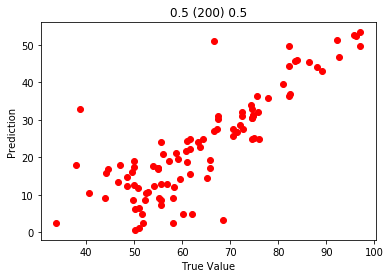

In [324]:
plt.scatter([val[0] for val in vals0], [val[1] for val in vals0], color="r")
# plt.hold()
# plt.scatter([val[0] for val in vals1], [val[1] for val in vals1], color="b")
plt.xlabel("True Value")
plt.ylabel("Prediction")
plt.title("0.5 (200) 0.5")
plt.show()